In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error 
from scipy import stats
import lightgbm as ltb

# Reading the datset

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Getting familiar with data

In [4]:
df.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [5]:
df.shape

(360336, 17)

In [6]:
df.isnull().sum()

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [8]:
df.duplicated().sum()

0

<AxesSubplot:xlabel='cost', ylabel='Count'>

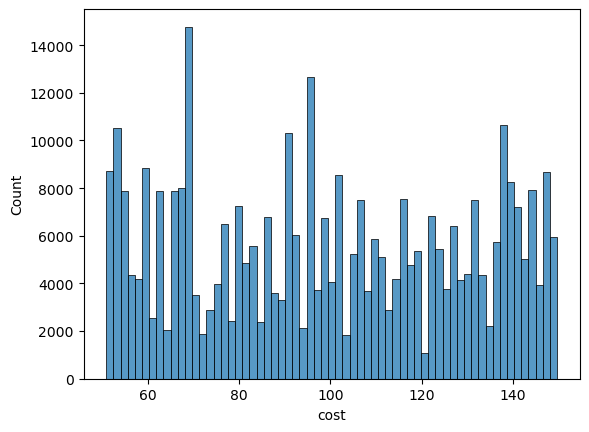

In [9]:
sns.histplot(df['cost'])

In [10]:
df.nunique()

id                            360336
store_sales(in millions)        1044
unit_sales(in millions)            6
total_children                     6
num_children_at_home               6
avg_cars_at home(approx).1         5
gross_weight                     384
recyclable_package                 2
low_fat                            2
units_per_case                    36
store_sqft                        20
coffee_bar                         2
video_store                        2
salad_bar                          2
prepared_food                      2
florist                            2
cost                             328
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,360336.0,180167.500000,104020.187637,0.00,90083.75,180167.50,270251.25,360335.00
store_sales(in millions),360336.0,6.337376,3.307980,0.51,3.72,5.78,8.40,22.92
unit_sales(in millions),360336.0,3.043881,0.784676,1.00,3.00,3.00,4.00,6.00
total_children,360336.0,2.456482,1.488992,0.00,1.00,2.00,4.00,5.00
num_children_at_home,360336.0,0.689390,1.214732,0.00,0.00,0.00,1.00,5.00
avg_cars_at home(approx).1,360336.0,2.203813,1.084293,0.00,1.00,2.00,3.00,4.00
gross_weight,360336.0,13.822071,4.614792,6.00,9.71,13.60,17.70,21.90
recyclable_package,360336.0,0.568086,0.495343,0.00,0.00,1.00,1.00,1.00
low_fat,360336.0,0.327797,0.469411,0.00,0.00,0.00,1.00,1.00
units_per_case,360336.0,18.972706,10.212912,1.00,10.00,20.00,28.00,36.00


In [12]:
df.corr()['cost']

id                           -0.000611
store_sales(in millions)     -0.012387
unit_sales(in millions)      -0.026509
total_children               -0.007482
num_children_at_home         -0.001727
avg_cars_at home(approx).1    0.027098
gross_weight                 -0.000116
recyclable_package           -0.001455
low_fat                      -0.001975
units_per_case                0.000180
store_sqft                   -0.049201
coffee_bar                   -0.052086
video_store                  -0.106786
salad_bar                    -0.098810
prepared_food                -0.098843
florist                      -0.110414
cost                          1.000000
Name: cost, dtype: float64

In [13]:
df.drop(columns='id', axis=1, inplace=True)

# Feature Engineering

In [14]:
df['children_ratio'] = df['total_children'] / df['num_children_at_home']
df['children_ratio'] = df['children_ratio'].replace([np.inf, -np.inf], 10)
df['facilities']= df['coffee_bar'] + df['video_store'] + df['salad_bar'] + df['florist']

In [15]:
cat=['total_children',
     'num_children_at_home',
     'avg_cars_at home(approx).1',
     'recyclable_package',
     'low_fat',
     'coffee_bar',
     'video_store',
     'salad_bar',
     'prepared_food',
     'florist']
df=pd.get_dummies(df, columns=cat)

## Train test split

In [16]:
X= df.drop(columns='cost')
y= df['cost']

## Box-Cox transformation

In [17]:
#y_fitted, fitted_lambda = stats.boxcox(y)

In [18]:
X_train, X_val, y_train, y_val= train_test_split(X,y, train_size=0.95, random_state=38)

# Model

In [19]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(verbose=0)
cbr.fit(X_train, y_train)
pred1 = cbr.predict(X_val)

In [20]:
print(cbr.score(X_val, y_val))

0.1189071773974083


In [21]:
mean_absolute_error(pred1,y_val)

23.816267077878383

In [22]:
mean_squared_log_error(pred1,y_val, squared=False)

0.29877135516929954

In [23]:
df_check1=pd.DataFrame(pred1,y_val)
df_check1.head(10)

,0
cost,
97.45,95.345770
118.36,107.947156
57.52,94.519318
54.11,84.499244
76.88,96.068373
147.82,124.156613
135.92,97.832514
89.90,116.752291
91.28,113.894624


In [24]:
xgb=XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb.fit(X_train, y_train)
pred2=xgb.predict(X_val)

In [25]:
print(xgb.score(X_val, y_val))

0.10104876940858565


In [26]:
mean_absolute_error(pred2,y_val)

24.2529595087736

In [27]:
mean_squared_log_error(pred2,y_val, squared=False)

0.3009303325900158

In [28]:
df_check2=pd.DataFrame(pred2,y_val)
df_check2.head(10)

,0
cost,
97.45,96.833092
118.36,107.497292
57.52,95.528702
54.11,86.580841
76.88,92.521858
147.82,120.165054
135.92,96.291382
89.90,111.055954
91.28,108.224594


In [29]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
pred3 = lgbm.predict(X_val)

In [30]:
print(lgbm.score(X_val, y_val))

0.10848609206173643


In [31]:
mean_absolute_error(pred3,y_val)

24.136095096070058

In [32]:
mean_squared_log_error(pred3,y_val, squared=False)

0.3007794986097558

In [33]:
df_check3=pd.DataFrame(pred3,y_val)
df_check3.head(10)

,0
cost,
97.45,96.458247
118.36,105.014144
57.52,95.841106
54.11,86.555563
76.88,93.845596
147.82,121.897083
135.92,96.472911
89.90,115.162800
91.28,108.178427


In [34]:
# from sklearn.model_selection import GridSearchCV
# model = CatBoostRegressor()
# parameters = {'depth' : [6,8,10],
#               'learning_rate' : [0.01, 0.05, 0.1],
#               'iterations'    : [30, 50, 100]
#               }

# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
# grid.fit(X_train, y_train)

In [35]:
# print(grid.best_params_)
# print(grid.score(X_val, y_val))

In [36]:
cbr2 = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=10)
cbr2.fit(X_train, y_train)
pred4 = cbr2.predict(X_val)

0:	learn: 29.7777286	total: 154ms	remaining: 15.2s
1:	learn: 29.6164846	total: 306ms	remaining: 15s
2:	learn: 29.4830412	total: 471ms	remaining: 15.2s
3:	learn: 29.3771951	total: 654ms	remaining: 15.7s
4:	learn: 29.2855571	total: 815ms	remaining: 15.5s
5:	learn: 29.1980765	total: 973ms	remaining: 15.2s
6:	learn: 29.1226092	total: 1.18s	remaining: 15.6s
7:	learn: 29.0558313	total: 1.33s	remaining: 15.4s
8:	learn: 28.9964761	total: 1.5s	remaining: 15.1s
9:	learn: 28.9381652	total: 1.66s	remaining: 14.9s
10:	learn: 28.8876889	total: 1.82s	remaining: 14.7s
11:	learn: 28.8464016	total: 1.98s	remaining: 14.6s
12:	learn: 28.8012940	total: 2.16s	remaining: 14.5s
13:	learn: 28.7652280	total: 2.32s	remaining: 14.3s
14:	learn: 28.7148856	total: 2.5s	remaining: 14.1s
15:	learn: 28.6796854	total: 2.65s	remaining: 13.9s
16:	learn: 28.6476817	total: 2.82s	remaining: 13.8s
17:	learn: 28.6223296	total: 2.97s	remaining: 13.5s
18:	learn: 28.5990186	total: 3.15s	remaining: 13.4s
19:	learn: 28.5701358	tota

In [37]:
print(cbr2.score(X_val, y_val))

0.12432751069641113


In [38]:
mean_absolute_error(pred4,y_val)

23.796563191601734

In [39]:
mean_squared_log_error(pred4,y_val, squared=False)

0.29808057083284734

In [40]:
df_check4=pd.DataFrame(pred4,y_val)
df_check4.head(10)

,0
cost,
97.45,94.888680
118.36,105.604790
57.52,93.531758
54.11,85.854615
76.88,95.150868
147.82,121.189212
135.92,97.405235
89.90,116.613876
91.28,108.871837


In [41]:
df_test.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


In [42]:
df_test1=df_test.copy()

In [43]:
df_test.drop(columns='id', axis=1, inplace=True)

In [44]:
df_test['children_ratio'] = df_test['total_children'] / df_test['num_children_at_home']
df_test['children_ratio'] = df_test['children_ratio'].replace([np.inf, -np.inf], 10)
df_test['facilities']= df_test['coffee_bar'] + df_test['video_store'] + df_test['salad_bar'] + df_test['florist']

In [45]:
cat=['total_children',
     'num_children_at_home',
     'avg_cars_at home(approx).1',
     'recyclable_package',
     'low_fat',
     'coffee_bar',
     'video_store',
     'salad_bar',
     'prepared_food',
     'florist']
df_test=pd.get_dummies(df_test, columns=cat)

# Test data

In [46]:
X_test=df_test

In [47]:
final_prediction = cbr2.predict(X_test)

# Prediction

In [48]:
final_test = pd.DataFrame({'id' : df_test1['id'], 'cost' : final_prediction})
final_test

,id,cost
0,360336,98.102875
1,360337,97.760472
2,360338,98.466182
3,360339,101.251570
4,360340,83.298429
...,...,...
240219,600555,104.469193
240220,600556,95.843669
240221,600557,98.285097
240222,600558,107.829190


# Submission

In [49]:
final_test.to_csv('submission.csv', index=False)